# Synthesis of Boolean networks from influence graph and dynamical constraints

A quick tutorial showing the features of BoNesis for the synthesis of Most Permissive Boolean Networks from network architecture and dynamical constraints.

In [1]:
import bonesis
import pandas as pd
from colomoto_jupyter import tabulate

The synthesis uses two inputs:
1. the domain of BNs, which can be a single BN, or specified by an influence graph
2. a table (dictionnary) specifying the (partial) observations of the systems

## Synthesis specification

### Influence graph

Let us define an influence graph from a list of pairwise interactions, with a sign.

In [2]:
influences = [
("Pax6","Pax6",dict(sign=1)),
("Pax6","Hes5",dict(sign=1)),
("Pax6","Mash1",dict(sign=1)),
("Hes5","Mash1",dict(sign=-1)),
("Hes5","Scl",dict(sign=1)),
("Hes5","Olig2",dict(sign=1)),
("Hes5","Stat3",dict(sign=1)),
("Mash1","Hes5",dict(sign=-1)),
("Mash1","Zic1",dict(sign=1)),
("Mash1","Brn2",dict(sign=1)),
("Zic1","Tuj1",dict(sign=1)),
("Brn2","Tuj1",dict(sign=1)),
("Scl","Olig2",dict(sign=-1)),
("Scl","Stat3",dict(sign=1)),
("Olig2","Scl",dict(sign=-1)),
("Olig2","Myt1L",dict(sign=1)),
("Olig2","Sox8",dict(sign=1)),
("Olig2","Brn2",dict(sign=-1)),
("Stat3","Aldh1L1",dict(sign=1)),
("Myt1L","Tuj1",dict(sign=1)),
]

# computing graph layout...


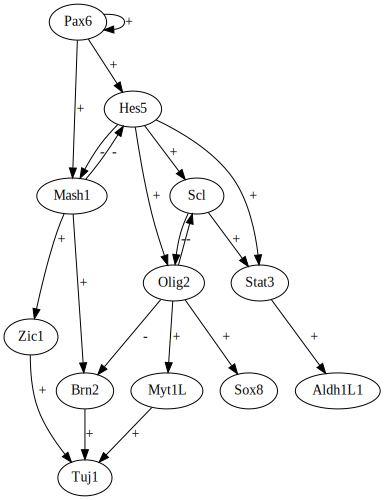

In [3]:
dom1 = bonesis.InfluenceGraph(influences)
dom1

Here, `dom1` delimits any BN that uses *at most* the listed influences, with the right sign. Thus, some solutions may use only a subset of this influence graph.

If you want to enforce BNs using *all* the given influences, use the option `exact=True`:

In [4]:
dom2 = bonesis.InfluenceGraph(influences, exact=True)

For influence graphs with large in-degrees, it is necessary to specify a bound on the number of clauses in the disjunction normal form (DNF) of the BNs with the `maxclause` argument. See `help(bonesis.InfluenceGraph)` for other options.

### Observations

They are specified by a Python dictionnary associating observation names to observed states of a subset of nodes:

In [5]:
data = {
    "zero": {n: 0 for n in dom1}, # all nodes are 0
    "init": {n: 1 if n == "Pax6" else 0 for n in dom1}, # all nodes are 0 but Pax6
    "tM": {"Pax6": 1, "Tuj1": 0, "Scl": 0, "Aldh1L1": 0, "Olig2": 0, "Sox8": 0},
    "fT": {"Pax6": 1, "Tuj1": 1, "Brn2": 1, "Zic1": 1, "Aldh1L1": 0, "Sox8": 0},
    "tO": {"Pax6": 1, "Tuj1": 0 ,"Scl": 0, "Aldh1L1": 0, "Olig2": 1, "Sox8": 0},    
    "fMS": {"Pax6": 1, "Tuj1": 0, "Zic1": 0, "Brn2": 0, "Aldh1L1": 0, "Sox8": 1},
    "tS": {"Pax6": 1, "Tuj1": 0, "Scl": 1, "Aldh1L1": 0, "Olig2": 0, "Sox8": 0},
    "fA": {"Pax6": 1, "Tuj1": 0, "Zic1": 0, "Brn2": 0, "Aldh1L1": 1, "Sox8": 0},
}
pd.DataFrame.from_dict(data, orient="index").fillna('')

,Pax6,Hes5,Mash1,Scl,Olig2,Stat3,Zic1,Brn2,Tuj1,Myt1L,Sox8,Aldh1L1
zero,0,0,0,0,0,0,0,0,0,0,0,0
init,1,0,0,0,0,0,0,0,0,0,0,0
tM,1,,,0,0,,,,0,,0,0
fT,1,,,,,,1,1,1,,0,0
tO,1,,,0,1,,,,0,,0,0
fMS,1,,,,,,0,0,0,,1,0
tS,1,,,1,0,,,,0,,0,0
fA,1,,,,,,0,0,0,,0,1


## Dynamical properties

In [6]:
bo = bonesis.BoNesis(dom1, data)

The `data` dictionnary specifies *observations* that can be used to constraint *configurations* (or states) of the network.

There are two shortcuts for binding a configuration to an observation:
`~bo.obs("A")` is a unique pre-defined configuration bound to the observation `"A"`;
`+bo.obs("A")` returns a *new* configuration bound to `"A"`. Thus in the following code:
```python
cfg1 = ~bo.obs("A")
cfg2 = ~bo.obs("A")
cfg3 = +bo.obs("A")
cfg4 = +bo.obs("A")
```
`cfg1` and `cfg2` refers to the *same* configuration; whereas `cfg3` and `cfg4` *may* be different.

### Attractor constraints

We detail two kind of attractor constraints: fixed points and trap spaces. Both are specified with the `fixed` predicate, which, depending on the argument will enforce the existence of one of the two kinds of attractor.

#### Fixed points

When giving a configuration as argument, `fixed` ensures that the configuration is a fixed point:

In [7]:
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));

#### Trap spaces

A trap space specification is given by an observation, which enforces that all the nodes in the given observations can never change of value (thus any reachable attractor have these nodes fixed):

In [8]:
fT_tp = bo.fixed(bo.obs("fT"))

### Reachability constraints

Reachability relates to the presence or absence of trajectory between two configurations.

#### Existence of trajectory

They can be specified using the `reach` function, or equivalently the `>=` operator between two configurations. The right-hand side can also be a `fixed` constraint.

In [9]:
~bo.obs("init") >= ~bo.obs("tM") >= fT_tp
~bo.obs("init") >= ~bo.obs("tO") >= ~bo.obs("fMS")
~bo.obs("init") >= ~bo.obs("tS") >= ~bo.obs("fA");

#### Absence of trajectory

They can be specified using the `nonreach` function, or equivalently the `/` operator between two configurations. The right-hand side can also be a `fixed` constraint.

In [10]:
~bo.obs("zero") / fT_tp
~bo.obs("zero") / ~bo.obs("fMS")
~bo.obs("zero") / ~bo.obs("fA");

### Enumeration of compatible BNs

Enumerations of solutions are done through iterators. The basic one being the `boolean_networks` which returns `mpbn.MPBooleanNetwork` objects.

In [11]:
for bn in bo.boolean_networks(limit=2): # limit is optional
    print(bn)

Grounding...done in 0.0s
Aldh1L1 <- Stat3
Brn2 <- Mash1
Hes5 <- !Mash1&Pax6
Mash1 <- !Hes5&Pax6
Myt1L <- 0
Olig2 <- Hes5&!Scl
Pax6 <- Pax6
Scl <- Hes5&!Olig2
Sox8 <- Olig2
Stat3 <- Hes5&Scl
Tuj1 <- Brn2
Zic1 <- Mash1

Aldh1L1 <- Stat3
Brn2 <- Mash1
Hes5 <- !Mash1
Mash1 <- !Hes5&Pax6
Myt1L <- 1
Olig2 <- Hes5&!Scl
Pax6 <- Pax6
Scl <- Hes5&!Olig2
Sox8 <- Olig2
Stat3 <- Hes5&Scl
Tuj1 <- Zic1
Zic1 <- Mash1



Display as a table:

In [12]:
solutions = list(bo.boolean_networks())
pd.DataFrame(solutions)

Grounding...done in 0.0s


,Aldh1L1,Brn2,Hes5,Mash1,Myt1L,Olig2,Pax6,Scl,Sox8,Stat3,Tuj1,Zic1
0,Stat3,Mash1,!Mash1,!Hes5&Pax6,1,Hes5&!Scl,Pax6,Hes5&!Olig2,Olig2,Scl,Brn2&Myt1L,Mash1
1,Stat3,Mash1,!Mash1,!Hes5&Pax6,0,Hes5&!Scl,Pax6,Hes5&!Olig2,Olig2,Scl,Zic1,Mash1
2,Stat3,Mash1,!Mash1,!Hes5,1,Hes5&!Scl,Pax6,Hes5&!Olig2,Olig2,Scl,Brn2&Zic1,Mash1
3,Stat3,Mash1,!Mash1&Pax6,!Hes5&Pax6,Olig2,Hes5&!Scl,Pax6,Hes5&!Olig2,Olig2,Scl,Brn2&Zic1,Mash1
4,Stat3,Mash1,!Mash1&Pax6,!Hes5&Pax6,Olig2,Hes5&!Scl,Pax6,Hes5&!Olig2,Olig2,Scl,(Brn2&Myt1L)|(Brn2&Zic1),Mash1
...,...,...,...,...,...,...,...,...,...,...,...,...
1115,Stat3,Mash1&!Olig2,!Mash1&Pax6,!Hes5,0,Hes5&!Scl,Pax6,!Olig2,Olig2,Hes5&Scl,Brn2|Zic1,Mash1
1116,Stat3,Mash1,!Mash1&Pax6,!Hes5,0,Hes5&!Scl,Pax6,!Olig2,Olig2,Hes5&Scl,Brn2&Zic1,Mash1
1117,Stat3,Mash1&!Olig2,!Mash1&Pax6,!Hes5,0,Hes5&!Scl,Pax6,!Olig2,Olig2,Hes5&Scl,Brn2&Zic1,Mash1
1118,Stat3,Mash1,!Mash1,!Hes5&Pax6,0,Hes5&!Scl,Pax6,!Olig2,Olig2,Hes5&Scl,Brn2|Zic1,Mash1


In [13]:
len(solutions)

1120

Resulting objects are `MPBooleanNetwor` from the [`mpbn`](https://mpbn.readthedocs.io/) Python library. One can then compute reachability and attractor properties directly:

In [14]:
pd.DataFrame(solutions[0].attractors())

,Aldh1L1,Brn2,Hes5,Mash1,Myt1L,Olig2,Pax6,Scl,Sox8,Stat3,Tuj1,Zic1
0,0,0,1,0,1,1,1,0,1,0,0,0
1,0,0,1,0,1,1,0,0,1,0,0,0
2,1,0,1,0,1,0,1,1,0,1,0,0
3,1,0,1,0,1,0,0,1,0,1,0,0
4,0,1,0,1,1,0,1,0,0,0,1,1


In [15]:
pd.DataFrame(solutions[0].attractors(reachable_from=data["init"]))

,Zic1,Tuj1,Stat3,Sox8,Scl,Pax6,Olig2,Myt1L,Mash1,Hes5,Brn2,Aldh1L1
0,1,1,0,0,0,1,0,1,1,0,1,0
1,0,0,0,1,0,1,1,1,0,1,0,0
2,0,0,1,0,1,1,0,1,0,1,0,1


### Universal constraints

We can also enforce universal constraints on fixed points and reachable fixed points.

#### Universal fixed points

The following constraint ensures that any fixed point has to match with at least one of the observation given in argument.

In [16]:
bo.all_fixpoints({bo.obs(obs) for obs in ["fA", "fMS", "fT", "zero"]});

#### Universal reachable fixed points

The following constraint ensures that any fixed point *reachable* from the configuration on left-hand side has to match with at least one of the given observation.

In [17]:
~bo.obs("init") >> "fixpoints" ^ {bo.obs(obs) for obs in ["fA", "fMS", "fT"]};

In [18]:
bo.boolean_networks().count()

Grounding...done in 0.0s


88

## Project solutions per nodes

To better understand the composition of the different solutions, one can project the solutions on each node: given a node A, it enumerates all the Boolean functions for A that are used in at least one full solution.

The projected solutions can be accessed from the following object:

In [19]:
projs = bo.local_functions()

Grounding...done in 0.0s


The `projs` object as `as_dict` method which offers a diret access to all the projected solutions. By default, it will enumerate the Boolean functions for each node. The method "count" instead returns the number of solutions per node. There is also a `keys` parameter to specify a subset of nodes for the computation.

In [20]:
projs.as_dict(method="count")

{'Pax6': 1,
 'Hes5': 1,
 'Mash1': 1,
 'Scl': 1,
 'Olig2': 1,
 'Stat3': 2,
 'Zic1': 1,
 'Brn2': 2,
 'Tuj1': 13,
 'Myt1L': 2,
 'Sox8': 1,
 'Aldh1L1': 1}

Note that the projected solutions gives an over-approximation of the full set of solutions: the full set of solutions is, in general, a strict subset of the cartesian product:

In [21]:
from functools import reduce
reduce(int.__mul__, _.values())

104

Access to the solutions of a specific node can be done as follows, where `view` is an object similar to the one returned by `bo.boolean_network()` (iterator over solutions).

In [22]:
with projs.view("Tuj1") as view:
    functions = [f for f in view]
[str(f) for f in functions]

['Zic1',
 'Myt1L|(Brn2&Zic1)',
 'Zic1|(Brn2&Myt1L)',
 '(Brn2&Myt1L)|(Brn2&Zic1)',
 'Myt1L|Zic1',
 'Brn2&Zic1',
 '(Brn2&Myt1L)|(Brn2&Zic1)|(Myt1L&Zic1)',
 'Brn2|Myt1L|Zic1',
 'Brn2|(Myt1L&Zic1)',
 '(Brn2&Zic1)|(Myt1L&Zic1)',
 'Brn2|Myt1L',
 'Brn2',
 'Brn2|Zic1']

Finally, `projs` has a `as_dataframe` method for pretty display of the projected solutions using *pandas*.

In [23]:
projs.as_dataframe()

,Pax6,Hes5,Mash1,Scl,Olig2,Stat3,Zic1,Brn2,Tuj1,Myt1L,Sox8,Aldh1L1
0,Pax6,!Mash1&Pax6,!Hes5&Pax6,Hes5&!Olig2,Hes5&!Scl,Scl,Mash1,Mash1&!Olig2,(Brn2&Zic1)|(Myt1L&Zic1),0,Olig2,Stat3
1,,,,,,Hes5&Scl,,Mash1,Brn2|Myt1L,Olig2,,
2,,,,,,,,,Zic1,,,
3,,,,,,,,,Brn2,,,
4,,,,,,,,,Zic1|(Brn2&Myt1L),,,
5,,,,,,,,,Brn2|Myt1L|Zic1,,,
6,,,,,,,,,Brn2&Zic1,,,
7,,,,,,,,,Myt1L|Zic1,,,
8,,,,,,,,,(Brn2&Myt1L)|(Brn2&Zic1),,,
9,,,,,,,,,Myt1L|(Brn2&Zic1),,,


## Exportation

A self-contained bash-script for customizing the ASP code and performing the enumeration off-line can be exported as follows.

In [24]:
view = bo.boolean_networks()

In [25]:
view.standalone(output_filename="tutorial.asp")